In [111]:
import math
import matplotlib.pyplot as plt
from qiskit.providers.aer.pulse import PulseSystemModel
import qutip.logging_utils as logging
from qutip import sigmax, sigmaz, sigmay, identity, basis
from qutip.qip.device import Processor
from qutip.qip.operations import hadamard_transform
from notebooks.qutip_wrapper import qutip_simulate_wrapper
%matplotlib inline
from notebooks.qiskit_scripts import *
import qutip.control.pulseoptim as cpo

In [112]:
from qiskit import IBMQ, pulse, ClassicalRegister, QuantumRegister

IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
armonk_backend = provider.get_backend('ibmq_armonk')

In [113]:
freq_est = 4974450442.586346
omegad0 = 31919806.545849085
dt = armonk_backend.configuration().dt
wq0 = 2 * np.pi * freq_est

scale_factor = 1e0
n_ts = 1600
evo_time = dt * n_ts * scale_factor
delta=0
delta_freq = delta / 2 / np.pi
scaled_omegad0 = omegad0 / scale_factor
# omegad0 = scaled_omegad0

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 0.]]
Control 1 Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[       0.         31919806.54584908]
 [31919806.54584908        0.        ]]
Control 2 Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.       +0.j         0.-31919806.54584908j]
 [0.+31919806.54584908j 0.       +0.j        ]]
Initial st

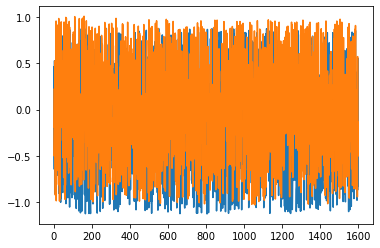

In [114]:
# Drift Hamiltonian
# H_d = wq0 * sigmaz() #wq0 * (1-sigmaz())/2 / omegad0
H_d = delta * (1 - sigmaz()) / 2
H_c = [scaled_omegad0 * sigmax(), scaled_omegad0 * sigmay()]

# start point for the gate evolution
U_0 = identity(2)
'''
    d(t)*H_c = H(t)
    d(t) [cos(phase(t)) * sigmax() + np.sin(phase) * sigmay()] = H(t)
    f(t) = d(t) * cos(phase(t))

    [d(t) cos(phase(t)) * omegad0 * sigmax(), d(t) sin(phase(t)) * omegad0 * sigmay()]
    [f(t) * omegad0 * sigmax(), f1(t) * omegad0 * sigmay()]
    f(t) = d(t) * cos(phase(t))
    f1(t) = d(t) * sin(phase(t))

    f, f1 are known

    d is unknown so is phase(t) so replace f(t) with f
    f/d = cosphase(
    f1/d = sinphase()
    d = f/cosphase(

    f1 = f/cos * sin = tan phase(
    f1/f = tan(phase(t))
    phase(t) = tan-1 (f1/f)

    d(t) = f/cos(tan-1(f1/f))


    now we have d_real = d(t) cos(phase), d_imag = d(t)sin(phase)
    d_r = f, dimag = f/cos(tan-1(f1/f)) sin(tan-1(f1/f))
    f* f1/f

    D(t) = f(t) + i * f1(t)
    drive is Re[d(t)]
    absolute value of D(t) is d(t)

'''
    #select complex amplitudes and take real and complex amplitudes
# Target for the gate evolution X gate
U_targ = sigmax()
# Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO

# Fidelity error target
fid_err_targ = 1e-10
# Maximum iterations for the optimisation algorithm
max_iter = 2000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 120
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'RND'

result = cpo.optimize_pulse_unitary(H_d, H_c, U_0, U_targ, n_ts, evo_time,
                                    fid_err_targ=fid_err_targ, min_grad=min_grad,
                                    max_iter=max_iter, max_wall_time=max_wall_time,
                                    out_file_ext=None, init_pulse_type=p_type,
                                    log_level=log_level, gen_stats=True, #amp_lbound=-1.0, amp_ubound=1.0,
                                    alg='GRAPE')
optimized_pulse_seq = result.final_amps
plt.plot(result.final_amps)

In [115]:
result.final_amps

array([[-0.27349435, -0.49533691],
       [ 0.46221587, -0.22803467],
       [-0.33532068, -0.19071694],
       ...,
       [-0.76530091, -0.46571187],
       [ 0.54976729, -0.50100128],
       [-0.81961608, -0.13919495]])

In [116]:
result.evo_full_final

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[-1.13957163e-06-8.44286994e-07j  4.01057497e-07+1.00000000e+00j]
 [-4.01057496e-07+1.00000000e+00j -1.13957164e-06+8.44286994e-07j]]

In [117]:
def normalizer(list_in, norm_bound=1):
    old_norm = 0
    for element in list_in:
        norm = element[0]**2 + element[1]**2
        if norm > old_norm:
            old_norm=norm
    scale = math.sqrt(old_norm * norm_bound)
    return [[a[0]/scale, a[1]/scale] for a in list_in]

In [118]:
optimized_pulse_seq = normalizer(optimized_pulse_seq)

In [119]:
def comp_converter(seq):
    return [complex(a[0], a[1]) for a in seq]

In [120]:
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = omegad0
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = wq0

# armonk_backend.configuration().qubit_lo_freq=[freq_est]
armonk_backend.defaults().qubit_freq_est=[freq_est]

In [121]:
gate, inst_map = pulse_to_gate_1q(armonk_backend, pulse.SamplePulse(comp_converter(optimized_pulse_seq)))
pulse_aer_backend = qiskit.providers.aer.PulseSimulator(
    configuration=armonk_backend.configuration())
armonk_model = PulseSystemModel.from_backend(armonk_backend)

/Users/benrosand/anaconda3/envs/qutip/lib/python3.8/site-packages/qiskit/pulse/pulse_lib/sample_pulse.py:149: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(SamplePulse(samples), DriveChannel(0))`.
  warnings.warn("Calling `{}` with a channel is deprecated. Instantiate the new `Play` "
/Users/benrosand/anaconda3/envs/qutip/lib/python3.8/site-packages/qiskit/pulse/pulse_lib/pulse.py:46: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(SamplePulse(array([-0.18779592-0.34012495j,  0.31738226-0.15658086j,
       -0.2302492 -0.1309565j , ..., -0.52549674-0.31978281j,
        0.37749977-0.34401441j, -0.56279246-0.09557874j])), DriveChannel(0))`.
  warnings.warn("Calling `{}` with a channel is deprecated. Instantiate the new `Play` "

In [122]:
#NOTE we removed measurement for qpt?
q = QuantumRegister(1)
c = ClassicalRegister(1)
my_circ = qiskit.QuantumCircuit(q, c)
my_circ.append(gate,q)
my_circ.measure([0], [0])

small_transp_circ = qiskit.transpile(my_circ, backend=pulse_aer_backend, basis_gates=armonk_backend.configuration().basis_gates + ['opt_gate'])
small_gate_sched = qiskit.schedule(small_transp_circ, inst_map=inst_map, backend=pulse_aer_backend, meas_map=[[0]])

job = qiskit.execute(small_gate_sched, pulse_aer_backend, shots=4096, system_model=armonk_model)

In [123]:
job.result().get_counts()

{'1': 1251, '0': 2845}

In [124]:
processor = Processor(N=1)

H_d = 0 * (1 - sigmaz()) / 2

processor.add_control(H_d, targets=0, label="sigmaz")
processor.add_control(omegad0 * sigmax(), targets=0, label="sigmax")
# processor.add_control(omegad0 * sigmay(), targets=0, label="sigmay")

# coef1 = [seq[0] for seq in optimized_pulse_seq]
# coef2 = [seq[1] for seq in optimized_pulse_seq]
tlist = np.array([dt * i for i in range(len(optimized_pulse_seq) + 1)])
#
# c1 = []
# c2 = []
# for i in optimized_pulse_seq:
#     c1.append(i[0])
#     c2.append(i[1])
processor.pulses[1].coeff = comp_converter(optimized_pulse_seq)
processor.pulses[1].tlist = tlist
# processor.pulses[2].coeff = coef2
# processor.pulses[2].tlist = tlist
# for pulse in processor.pulses:
# pulse.print_info()

basis0 = basis(2, 0)
result = processor.run_state(init_state=basis0)
# result.states[-1].tidyup(1.e-5)
# result.states
# basis(2,0)

print(result.states[-1].tidyup(1.e-5))
result.states

/Users/benrosand/anaconda3/envs/qutip/lib/python3.8/site-packages/qutip/qip/pulse.py:610: ComplexWarning: Casting complex values to real discards the imaginary part
  new_coeff[new_ind] = old_coeffs[old_ind]


Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.46720124+0.j        ]
 [0.        +0.88415101j]]


[Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[1.]
  [0.]],
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[0.99999911+0.j       ]
  [0.        +0.0013317j]],
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[0.99999958+0.j        ]
  [0.        -0.00091944j]],
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[0.99999975+0.j        ]
  [0.        +0.00071374j]],
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[0.99999262+0.j        ]
  [0.        +0.00384274j]],
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[0.99999918+0.j        ]
  [0.        +0.00127891j]],
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[0.9999842+0.j       ]
  [0.       +0.0056205j]],
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[0.99996651+0.j        ]
  [0.        +0.008